# Quantum Neural Networks

In [10]:
import pandas as pd
from IPython.core.display_functions import clear_output
from qiskit import Aer, QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA, ADAM, SLSQP
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, TwoLocal, PauliFeatureMap
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
import matplotlib.pyplot as plt

## Provide configuration options for the learning process
---

In [11]:
RANDOM_SEED = 42
SHOTS = 1024
TRAIN_DATA_SPLIT = 0.75

## Prepare and analyze dataset
---

In [12]:
df = pd.read_csv('datasets/adhoc.csv', index_col=0)
df.count()

feature_1    1000
feature_2    1000
label        1000
dtype: int64

In [13]:
display(df)

,feature_1,feature_2,label
0,1.759292,1.130973,0.0
1,0.816814,6.157522,0.0
2,2.136283,0.565487,0.0
3,5.717699,1.193805,0.0
4,3.518584,0.251327,0.0
...,...,...,...
995,1.507964,0.879646,1.0
996,3.769911,4.272566,1.0
997,0.816814,3.769911,1.0
998,2.576106,2.638938,1.0


In [14]:
print(f'Rows with label = 1: #{df.where(df["label"] == 1.0)["label"].count()}')
print(f'Rows with label = 0: #{df.where(df["label"] == 0.0)["label"].count()}')

feature_dimension = df.shape[1] - 1
print(f"Feature dimension: {feature_dimension}")

Rows with label = 1: #500
Rows with label = 0: #500
Feature dimension: 2


In [15]:
# Split the data into training and test sets
all_features = df.copy()
all_labels = all_features.pop('label')

train = df.sample(frac=0.75, random_state=42)
test = df.drop(train.index)

# Separate the features from the labels
train_features = train.copy()
test_features = test.copy()

train_labels = train_features.pop('label')
test_labels = test_features.pop('label')

## Setup quantum circuit
---

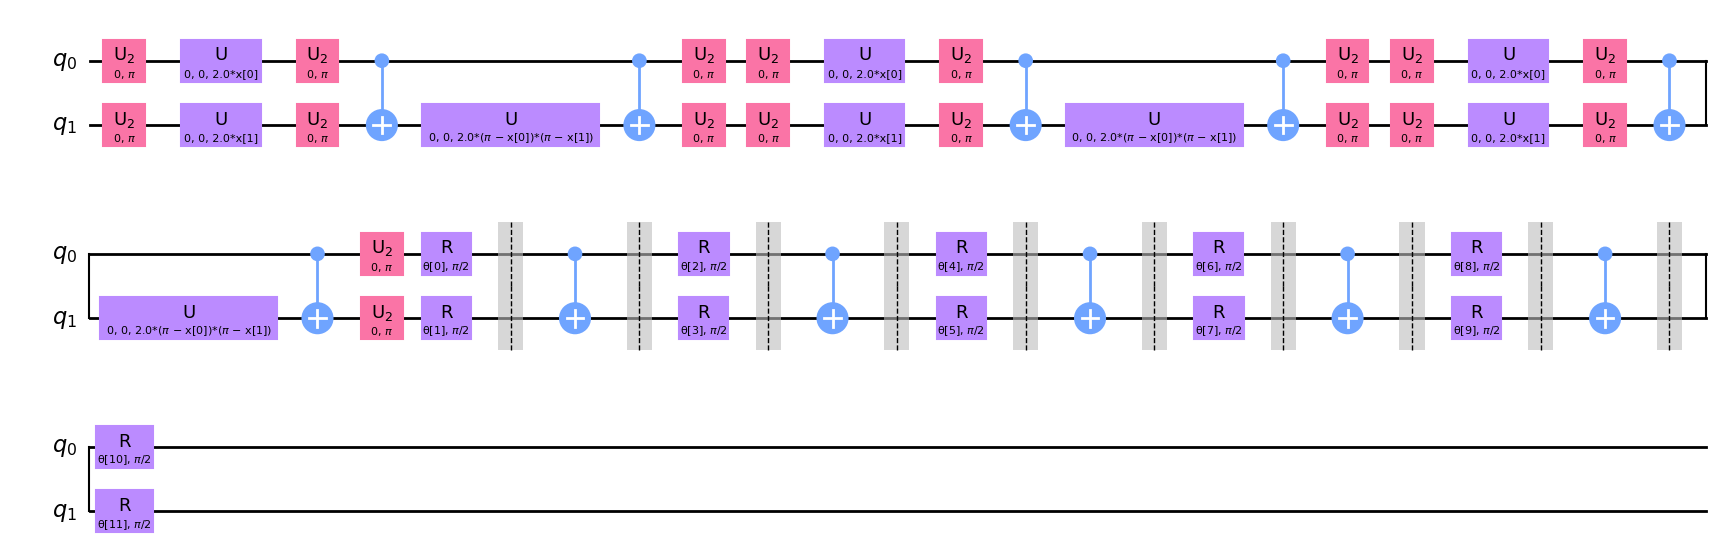

In [33]:
algorithm_globals.random_seed = RANDOM_SEED
quantum_instance = QuantumInstance(Aer.get_backend("qasm_simulator"), shots=SHOTS)

# feature_map = ZZFeatureMap(feature_dimension=feature_dimension, entanglement='linear')
feature_map = PauliFeatureMap(feature_dimension=feature_dimension, reps=3, paulis=['Z', 'XX'])
ansatz = RealAmplitudes(num_qubits=feature_map.num_qubits, insert_barriers=True, reps=5)
# ansatz = TwoLocal(FEATURES, 'ry', 'cx', 'linear', reps=2, insert_barriers=True)
qc = QuantumCircuit(ansatz.num_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)
qc.decompose().decompose().draw(output='mpl')

In [34]:
def parity(x):
    # return "{:b}".format(x)[0] == '1'
    return "{:b}".format(x).count("1") % 2

sampler_qnn = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    output_shape=2 ** qc.num_qubits,
    interpret=parity,
)

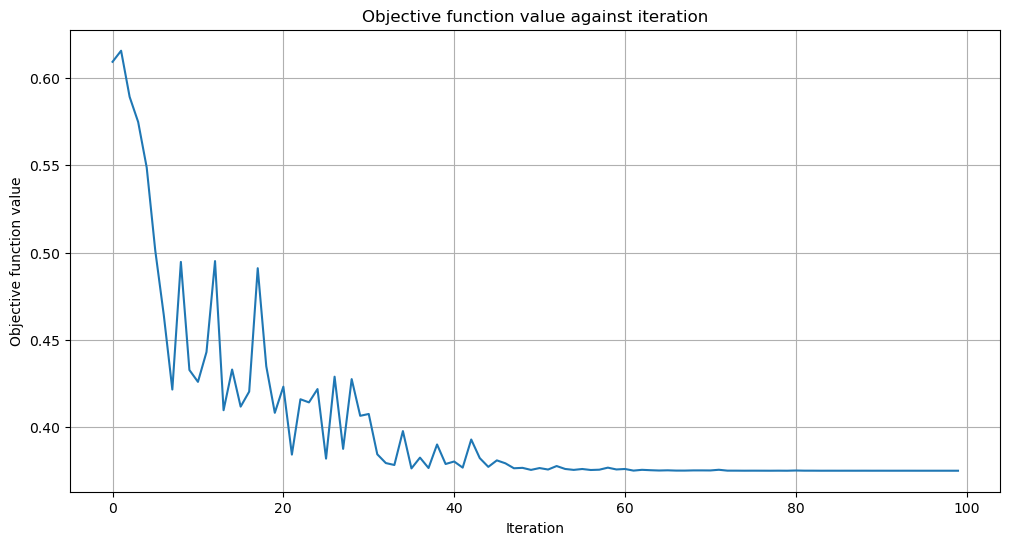

In [35]:
objective_func_vals = []

def callback_graph(_weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.grid(True)
    plt.show()

sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn,
    optimizer=COBYLA(maxiter=100),
    # optimizer=ADAM(maxiter=500),
    # optimizer=SLSQP(maxiter=250),
    callback=callback_graph
)

# Train the model
plt.rcParams["figure.figsize"] = (12, 6)
sampler_classifier.fit(train_features, train_labels)

In [31]:
score = sampler_classifier.score(test_features, test_labels)
print(f"Accuracy: {score}")

Accuracy: 0.892
